# **讀書會第二組 week7**

In [ ]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

Text(0.5, 1.0, '聲量圖')

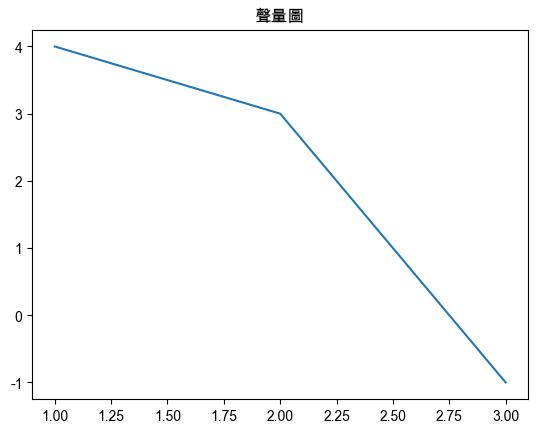

In [ ]:
# plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")


# **文字前處理**

**sna2024s_2_eb4bb8bde2_9.csv 為我們要分析的聯合新聞網資料**.

**版別:**股市、產經、要聞

**時間範圍：**24/01~24/03

In [ ]:
car = pd.read_csv("raw_data/sna2024s_2_eb4bb8bde2_9.csv")  # 匯資料
car.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,中國拖船闖台水域 海巡署：伴航監控和廣播驅離,2024-01-02 11:09:00,要聞,https://udn.com/news/story/10930/7680054,軍事粉專記錄兩艘中國籍拖船於跨年期間闖台灣水域，其中「寧海拖5001」今天凌晨位置在鵝鑾鼻東...,NaN,UDN
1,2,確保幻象機戰力 國軍斥資102億元採購發動機零附件,2024-01-04 16:24:00,要聞,https://udn.com/news/story/10930/7686167,為確保幻象戰機零附件及戰力無虞，政府電子採購網今天公布決標資訊，國防部國防採購室駐歐採購組與...,NaN,UDN
2,3,國防部：2枚中共空飄氣球昨穿越台灣本島中南部上空,2024-01-09 10:06:00,要聞,https://udn.com/news/story/10930/7695181,國防部上午發布中共解放軍台海周邊海、空域動態，情資顯示昨（8）日有4枚中共空飄氣球逾越海峽中...,NaN,UDN


 **查看各版文章筆數**

 對欄位重新命名，因為原本爬下來的欄位名稱與其對應的資料有誤



In [ ]:
print(f"number of posts: {car.shape[0]}")
print(f"date range: {(car['artDate'].min(), car['artDate'].max())}")
print(f"category: \n{car['artCatagory'].value_counts()}")
car.rename(columns={'artSecondCatagory': 'artURl','artUrl': 'artcontent','artContent': 'content'},inplace=True)
car.drop('content',axis='columns')
# car = car[car['artCatagory'] != '要聞']
car.head()

number of posts: 6150
date range: ('2024-01-01 00:11:00', '2024-03-31 23:59:00')
category: 
artCatagory
產經    3067
股市    2578
要聞     505
Name: count, dtype: int64


,system_id,artTitle,artDate,artCatagory,artURl,artcontent,content,dataSource
0,1,中國拖船闖台水域 海巡署：伴航監控和廣播驅離,2024-01-02 11:09:00,要聞,https://udn.com/news/story/10930/7680054,軍事粉專記錄兩艘中國籍拖船於跨年期間闖台灣水域，其中「寧海拖5001」今天凌晨位置在鵝鑾鼻東...,NaN,UDN
1,2,確保幻象機戰力 國軍斥資102億元採購發動機零附件,2024-01-04 16:24:00,要聞,https://udn.com/news/story/10930/7686167,為確保幻象戰機零附件及戰力無虞，政府電子採購網今天公布決標資訊，國防部國防採購室駐歐採購組與...,NaN,UDN
2,3,國防部：2枚中共空飄氣球昨穿越台灣本島中南部上空,2024-01-09 10:06:00,要聞,https://udn.com/news/story/10930/7695181,國防部上午發布中共解放軍台海周邊海、空域動態，情資顯示昨（8）日有4枚中共空飄氣球逾越海峽中...,NaN,UDN
3,4,因應中共空飄氣球 國防部執行反偵蒐隱掩蔽部署,2024-01-09 11:43:00,要聞,https://udn.com/news/story/10930/7695498,針對中共空飄氣球近期密集飄越海峽中線，部分飛越本島上空，國防部情次室情報次長室情研中心情報官...,NaN,UDN
4,5,國防部：不會擊毀中共空飄氣球,2024-01-09 12:51:00,要聞,https://udn.com/news/story/10930/7695730,國防部作計室聯合作戰計畫處副處長王家駿上校今天表示，中共對我施放空飄氣球，國軍會保持全程監控...,NaN,UDN


# **資料清理**
**利用標點符號斷句**

In [ ]:
# 過濾 nan 的資料
car = car.dropna(subset=['artTitle'])
car = car.dropna(subset=['artcontent'])
# 移除網址格式
car["artcontent"] = car.artcontent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
car["artTitle"] = car["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
car["artcontent"] = car.artcontent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
car["artTitle"] = car["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
car.head(3)

,system_id,artTitle,artDate,artCatagory,artURl,artcontent,content,dataSource
0,1,中國拖船闖台水域海巡署伴航監控和廣播驅離,2024-01-02 11:09:00,要聞,https://udn.com/news/story/10930/7680054,軍事粉專記錄兩艘中國籍拖船於跨年期間闖台灣水域其中寧海拖今天凌晨位置在鵝鑾鼻東面不到浬海巡署...,NaN,UDN
1,2,確保幻象機戰力國軍斥資億元採購發動機零附件,2024-01-04 16:24:00,要聞,https://udn.com/news/story/10930/7686167,為確保幻象戰機零附件及戰力無虞政府電子採購網今天公布決標資訊國防部國防採購室駐歐採購組與法國...,NaN,UDN
2,3,國防部枚中共空飄氣球昨穿越台灣本島中南部上空,2024-01-09 10:06:00,要聞,https://udn.com/news/story/10930/7695181,國防部上午發布中共解放軍台海周邊海空域動態情資顯示昨日有枚中共空飄氣球逾越海峽中線其中兩枚穿...,NaN,UDN


**文集的標題和內容納入分析的內容，成為content欄位**

In [ ]:
car["content"] = car["artTitle"] + car["artcontent"]
car = car[["artcontent", "artURl", "artCatagory"]]  # 文章內容 文章連結
car.head()

,artcontent,artURl,artCatagory
0,軍事粉專記錄兩艘中國籍拖船於跨年期間闖台灣水域其中寧海拖今天凌晨位置在鵝鑾鼻東面不到浬海巡署...,https://udn.com/news/story/10930/7680054,要聞
1,為確保幻象戰機零附件及戰力無虞政府電子採購網今天公布決標資訊國防部國防採購室駐歐採購組與法國...,https://udn.com/news/story/10930/7686167,要聞
2,國防部上午發布中共解放軍台海周邊海空域動態情資顯示昨日有枚中共空飄氣球逾越海峽中線其中兩枚穿...,https://udn.com/news/story/10930/7695181,要聞
3,針對中共空飄氣球近期密集飄越海峽中線部分飛越本島上空國防部情次室情報次長室情研中心情報官黃明...,https://udn.com/news/story/10930/7695498,要聞
4,國防部作計室聯合作戰計畫處副處長王家駿上校今天表示中共對我施放空飄氣球國軍會保持全程監控視其...,https://udn.com/news/story/10930/7695730,要聞


In [ ]:
print(f"total docs: {car.shape[0]}")

total docs: 6150


# **斷詞設定**

In [ ]:
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [ ]:
car["words"] = car["artcontent"].apply(getToken).map(" ".join)
car.head()

Building prefix dict from /Users/arron/Desktop/try_sma/dict/dict.txt.big ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.u2ac362be0ae0fb1086dfddf0372fc8f6.cache
Loading model cost 0.588 seconds.
Prefix dict has been built successfully.


,artcontent,artURl,artCatagory,words
0,軍事粉專記錄兩艘中國籍拖船於跨年期間闖台灣水域其中寧海拖今天凌晨位置在鵝鑾鼻東面不到浬海巡署...,https://udn.com/news/story/10930/7680054,要聞,軍事 粉專 記錄 兩艘 中國籍 拖船 期間 闖台灣 水域 寧海 今天 凌晨 位置 鵝鑾鼻 東...
1,為確保幻象戰機零附件及戰力無虞政府電子採購網今天公布決標資訊國防部國防採購室駐歐採購組與法國...,https://udn.com/news/story/10930/7686167,要聞,確保 幻象 戰機 附件 戰力 無虞 政府 電子 採購網 今天 公布 決標 資訊 國防部 國防...
2,國防部上午發布中共解放軍台海周邊海空域動態情資顯示昨日有枚中共空飄氣球逾越海峽中線其中兩枚穿...,https://udn.com/news/story/10930/7695181,要聞,國防部 上午 發布 中共 解放軍 台海 周邊 空域 動態 情資 顯示 昨日 有枚 中共 空飄...
3,針對中共空飄氣球近期密集飄越海峽中線部分飛越本島上空國防部情次室情報次長室情研中心情報官黃明...,https://udn.com/news/story/10930/7695498,要聞,中共 空飄 氣球 近期 密集 飄越 海峽 中線 部分 飛越 本島 上空 國防部 情次室 情報...
4,國防部作計室聯合作戰計畫處副處長王家駿上校今天表示中共對我施放空飄氣球國軍會保持全程監控視其...,https://udn.com/news/story/10930/7695730,要聞,國防部 作計室 聯合作戰 計畫 副處長 王家駿 上校 今天 表示 中共 施放 空飄 氣球 國...


# **資料集檢視**

In [ ]:
print(f"total posts: {len(car['artURl'].unique())}")
print(f"category: \n{car['artCatagory'].value_counts()}")

total posts: 6150
category: 
artCatagory
產經    3067
股市    2578
要聞     505
Name: count, dtype: int64


# **分類模型的訓練流程**
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [ ]:
data = car
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

5521    工業 電腦 大廠 樺漢日 公布 去年 財報 營業 利益 億元 年增 營收 營業 利益 改寫 ...
235     淡江大學 兩岸關係 研究 中心 主任 五岳 分析 台灣 總統大選 結束 中共 對台 政策 有...
2391    先前 傳出 台積奈米將 落腳 嘉義 科學園區 國科會 主委 吳政忠 表示 環境部 審查 嘉義...
4343    美股 今年 開年 表現 強勢 主要 指數 迭創 歷史 新高 台股 新春 紅盤 跳空 大漲 歷...
3706    概念股 龍頭 廠輝 財報 報喜 盤後漲 逾並 帶動 台積 電盤 走高 激勵 台股 概念股 調...
Name: words, dtype: object
5521    股市
235     要聞
2391    產經
4343    股市
3706    股市
Name: artCatagory, dtype: object


**要聞本身跟ai相關的文章沒有那麼豐富**

In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
產經    49.869919
股市    41.918699
要聞     8.211382
Name: proportion, dtype: float64

train percentage :
artCatagory
產經    50.406504
股市    41.416957
要聞     8.176539
Name: proportion, dtype: float64

test percentage :
artCatagory
產經    48.617886
股市    43.089431
要聞     8.292683
Name: proportion, dtype: float64


# **將文章轉為DTM**



# **套入正式資料集**

In [ ]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [ ]:
X_train.head()

5521    工業 電腦 大廠 樺漢日 公布 去年 財報 營業 利益 億元 年增 營收 營業 利益 改寫 ...
235     淡江大學 兩岸關係 研究 中心 主任 五岳 分析 台灣 總統大選 結束 中共 對台 政策 有...
2391    先前 傳出 台積奈米將 落腳 嘉義 科學園區 國科會 主委 吳政忠 表示 環境部 審查 嘉義...
4343    美股 今年 開年 表現 強勢 主要 指數 迭創 歷史 新高 台股 新春 紅盤 跳空 大漲 歷...
3706    概念股 龍頭 廠輝 財報 報喜 盤後漲 逾並 帶動 台積 電盤 走高 激勵 台股 概念股 調...
Name: words, dtype: object

In [ ]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<4305x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 363509 stored elements in Compressed Sparse Row format>

In [ ]:
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 3, 1]])

In [ ]:
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])

['一年' '一度' '一次' '一直' '三大' '三年' '三星' '上升' '上半年' '上市']


In [ ]:
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一年']

{'工業': 321, '電腦': 956, '大廠': 269, '公布': 118, '去年': 174, '財報': 835, '營業': 610, '利益': 139, '億元': 91, '年增': 340, '營收': 609, '歷史': 562, '新高': 482, '紀錄': 702, '表現': 789, '持續': 413, '稅後': 679, '淨利': 593, '每股': 566, '盈餘': 651, '個股': 82, '毛利率': 568, '百分點': 650, '年減': 345, '平均': 337, '表示': 790, '相關': 660, '繼續': 739, '受惠': 182, '三大': 4, '事業': 41, '設計': 815, '品牌': 208, '通路': 884, '系統': 701, '整合': 470, '營運': 611, '規模': 801, '尤其': 311, '包含': 158, '子公司': 282, '擴大': 445, '接單': 426, '動能': 156, '轉型': 870, '市場': 327, '布局': 330, '效益': 466, '展現': 315, '集團': 945, '金額': 924, '年增率': 341, '成長': 390, '關鍵': 937, '原因': 173, '第季': 693, '影響': 369, '匯率': 160, '持平': 411, '比重': 567, '增長': 257, '主因': 28, '平台': 336, '方案': 485, '發酵': 649, '提升': 436, '管理': 696, '展望': 314, '今年': 59, '信心': 79, '目前': 654, '完成': 286, '後續': 371, '正式': 561, '加入': 149, '業務': 539, '指出': 415, '全球': 110, '雲端': 948, '高速': 992, '運算': 896, '半導體': 166, '電動車': 953, '產業': 631, '樂觀': 545, '看待': 663, '智慧': 505, '製造': 795, '解決方案': 805, '設備': 814, '服務': 526

0

In [ ]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(4305, 1000)
(1845, 1000)


**建立分類器模型**

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(vec_train, y_train)
clf

LogisticRegression(max_iter=1000)

In [ ]:
clf.classes_

array(['產經', '股市', '要聞'], dtype=object)

In [ ]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['產經' '產經' '產經' '產經' '產經' '產經' '股市' '股市' '產經' '股市']


In [ ]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(1845, 3)


array([9.99997625e-01, 5.21259549e-11, 2.37535151e-06])

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          產經       0.84      0.88      0.86       897
          股市       0.87      0.83      0.85       795
          要聞       0.92      0.89      0.90       153

    accuracy                           0.86      1845
   macro avg       0.88      0.87      0.87      1845
weighted avg       0.86      0.86      0.86      1845



In [ ]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[790,  96,  11],
       [132, 662,   1],
       [ 14,   3, 136]])

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '產經'), Text(0, 1.5, '股市'), Text(0, 2.5, '要聞')])

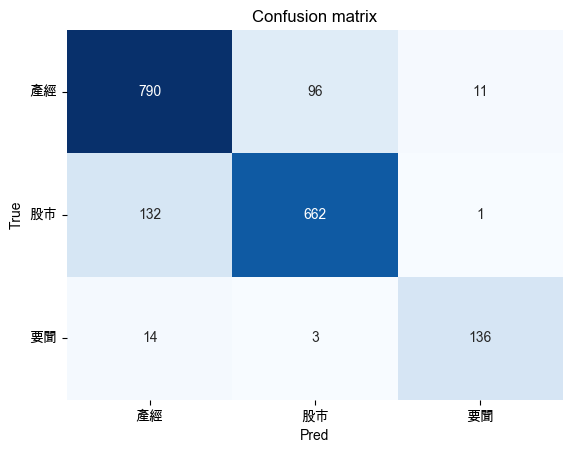

In [ ]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

# **TF-IDF**
改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果


In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.07810469,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04900399, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08926867, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02011375,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

**效果稍微上升**

In [ ]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          產經       0.87      0.91      0.89       897
          股市       0.90      0.87      0.89       795
          要聞       0.96      0.86      0.91       153

    accuracy                           0.89      1845
   macro avg       0.91      0.88      0.89      1845
weighted avg       0.89      0.89      0.89      1845



# **CV(cross-validation)**
在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

In [ ]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.0649097 , 0.06184292, 0.05596495, 0.06063795, 0.06040072]),
 'score_time': array([0.00696921, 0.00700998, 0.00648904, 0.00691485, 0.00678992]),
 'test_f1_macro': array([0.86126446, 0.88978518, 0.85113899, 0.87799492, 0.88819158]),
 'test_precision_macro': array([0.89581621, 0.90668503, 0.88182529, 0.91122666, 0.90005506]),
 'test_recall_macro': array([0.83531821, 0.87521159, 0.82778832, 0.85303551, 0.87799881])}


In [ ]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          產經       0.86      0.90      0.88      2170
          股市       0.88      0.86      0.87      1783
          要聞       0.96      0.81      0.88       352

    accuracy                           0.87      4305
   macro avg       0.90      0.85      0.87      4305
weighted avg       0.87      0.87      0.87      4305



# **比較不同模型之間的效果**

In [ ]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()

    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")

    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_

    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          產經       0.86      0.90      0.88      2170
          股市       0.88      0.86      0.87      1783
          要聞       0.96      0.81      0.88       352

    accuracy                           0.87      4305
   macro avg       0.90      0.85      0.87      4305
weighted avg       0.87      0.87      0.87      4305



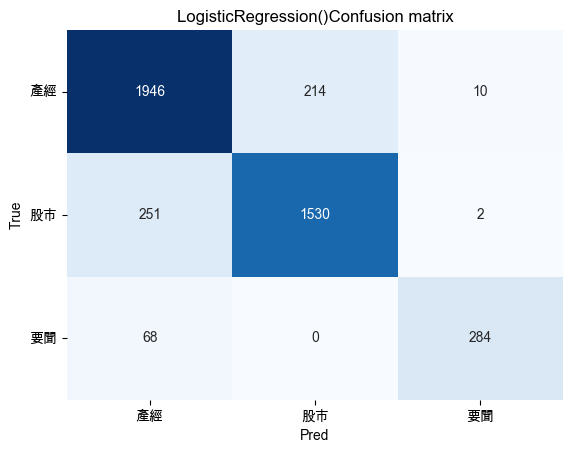

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

**Logistic regression、Decision tree、SVM、Random forest，四個模型的分類結果**

now training: clf_logistic
              precision    recall  f1-score   support

          產經       0.86      0.90      0.88      2170
          股市       0.88      0.86      0.87      1783
          要聞       0.96      0.81      0.88       352

    accuracy                           0.87      4305
   macro avg       0.90      0.85      0.87      4305
weighted avg       0.87      0.87      0.87      4305

now training: clf_dtree
              precision    recall  f1-score   support

          產經       0.81      0.80      0.80      2170
          股市       0.79      0.80      0.80      1783
          要聞       0.78      0.81      0.80       352

    accuracy                           0.80      4305
   macro avg       0.80      0.80      0.80      4305
weighted avg       0.80      0.80      0.80      4305

now training: clf_svm
              precision    recall  f1-score   support

          產經       0.86      0.89      0.87      2170
          股市       0.87      0.86      0.86      1783
  

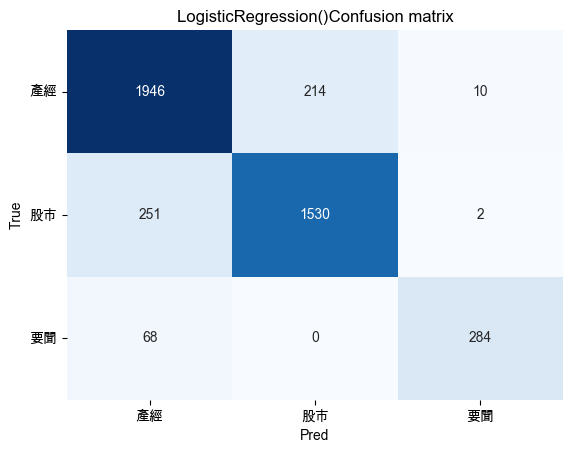

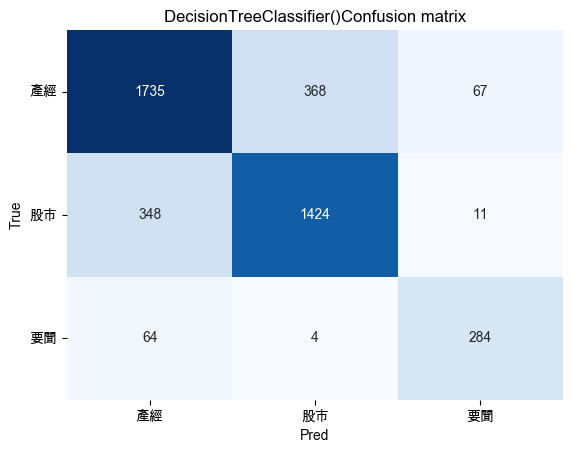

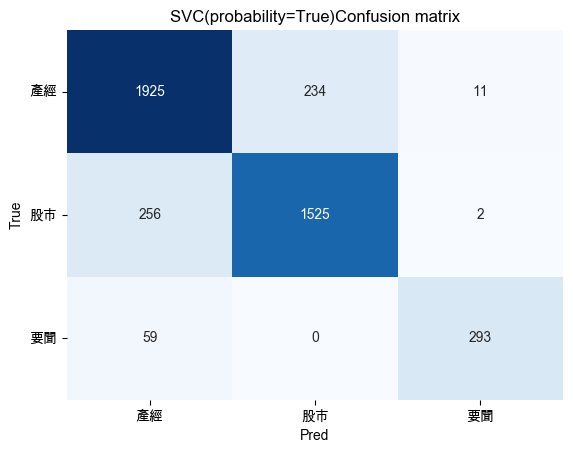

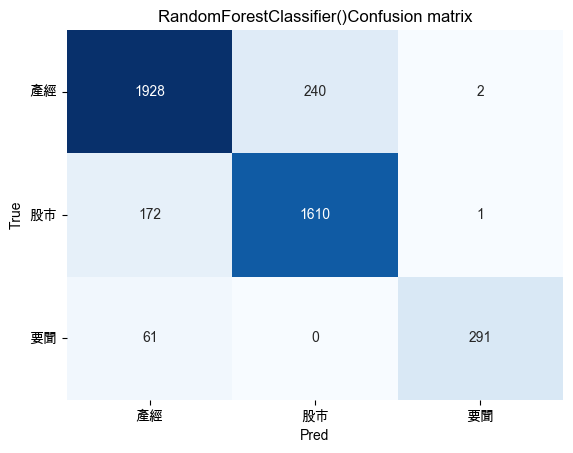

In [ ]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [ ]:
result_set['clf_logistic']

{'產經': {'precision': 0.8591611479028698,
  'recall': 0.896774193548387,
  'f1-score': 0.8775648252536641,
  'support': 2170.0},
 '股市': {'precision': 0.8772935779816514,
  'recall': 0.8581043185642176,
  'f1-score': 0.8675928551176637,
  'support': 1783.0},
 '要聞': {'precision': 0.9594594594594594,
  'recall': 0.8068181818181818,
  'f1-score': 0.8765432098765432,
  'support': 352.0},
 'accuracy': 0.8734030197444832,
 'macro avg': {'precision': 0.8986380617813268,
  'recall': 0.8538988979769289,
  'f1-score': 0.8739002967492904,
  'support': 4305.0},
 'weighted avg': {'precision': 0.8748719791452362,
  'recall': 0.8734030197444832,
  'f1-score': 0.8733512058889172,
  'support': 4305.0}}

**分類效果最好的model為Random forest**

In [ ]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_rf
{'accuracy': 0.8894308943089431,
 'macro avg': {'f1-score': 0.8925247327813186,
               'precision': 0.9174152450479548,
               'recall': 0.8727187754516875,
               'support': 4305.0},
 'weighted avg': {'f1-score': 0.8895334924896452,
                  'precision': 0.8910870316087699,
                  'recall': 0.8894308943089431,
                  'support': 4305.0},
 '產經': {'f1-score': 0.8903255599168783,
        'precision': 0.8921795465062471,
        'recall': 0.8884792626728111,
        'support': 2170.0},
 '股市': {'f1-score': 0.8863198458574181,
        'precision': 0.8702702702702703,
        'recall': 0.9029725182277061,
        'support': 1783.0},
 '要聞': {'f1-score': 0.9009287925696594,
        'precision': 0.9897959183673469,
        'recall': 0.8267045454545454,
        'support': 352.0}}


In [ ]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          產經       0.87      0.90      0.88       897
          股市       0.89      0.87      0.88       795
          要聞       0.96      0.86      0.91       153

    accuracy                           0.88      1845
   macro avg       0.90      0.88      0.89      1845
weighted avg       0.88      0.88      0.88      1845



**在我們資料集上分類表現最好的模型為Random forest，不過其餘三個除了decision tree以外的效果其實都不錯**

# **分析可解釋模型的結果**

In [ ]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds,
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

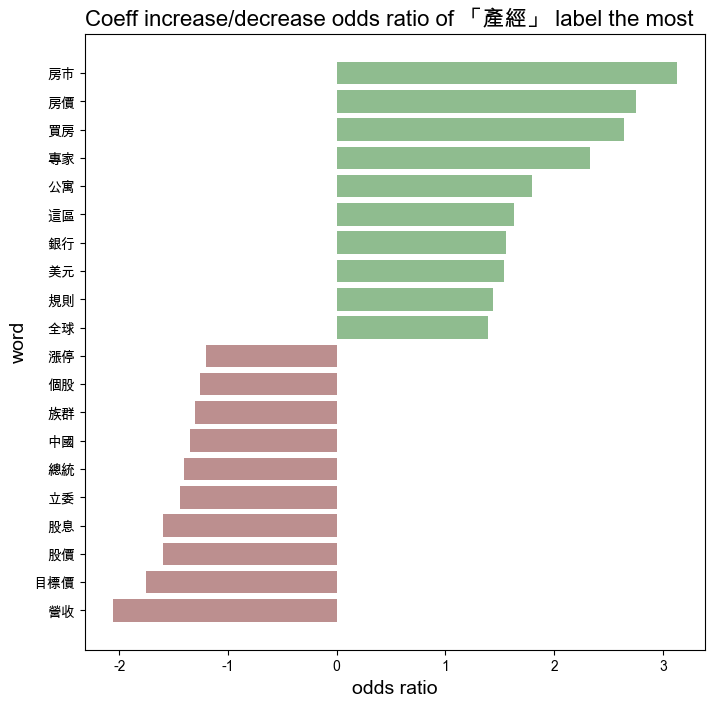

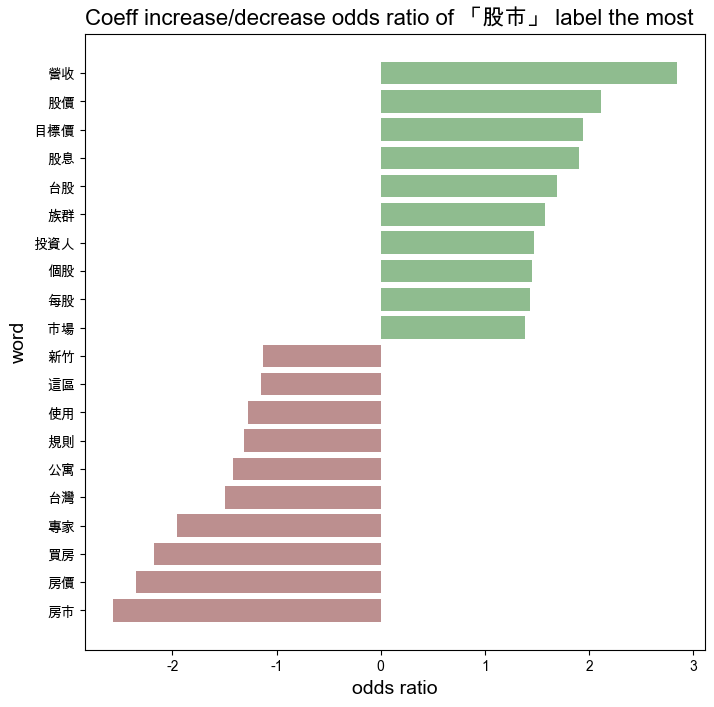

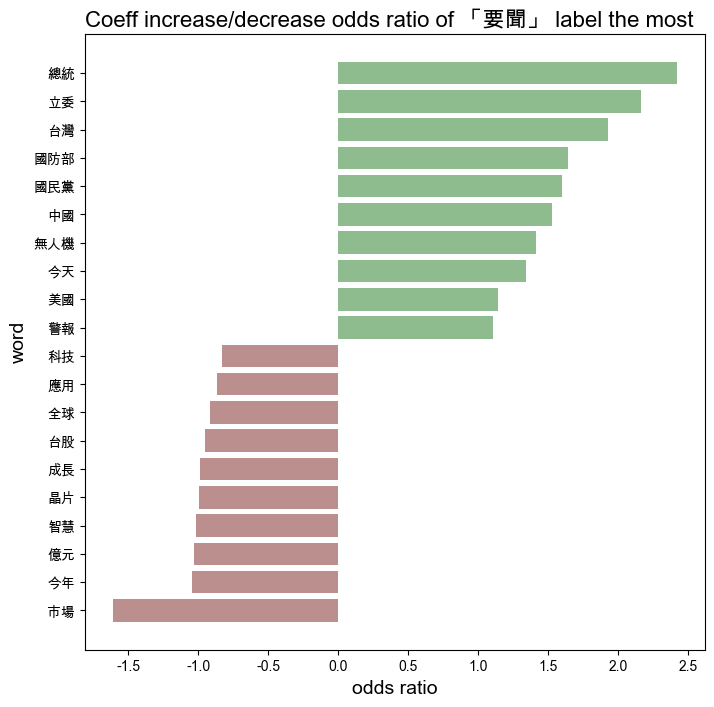

In [ ]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

# **預測文章類別**
資料集同樣爬取聯合新聞網：要聞、股市、產經三個版別，但時間範圍不同
改為：24/4/4~4/7

In [ ]:
ct = pd.read_csv("./raw_data/sna2024s_2_eb4bb8bde2_9-2.csv")
ct

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,專家：陸射劍二部署全台 完備中低層防空間隙,2024-04-04 12:22:00,要聞,https://udn.com/news/story/10930/7877412,陸射劍二防空系統將於4月9日首次參與演訓，專家學者分析，陸射劍二的部署，等同於完備台灣中低層...,NaN,UDN
1,2,《鮮花》爆紅樂團回春丹PO文「中國台灣」 台灣祭宣布「取消演出」：我們還有信念,2024-04-02 20:04:00,要聞,https://udn.com/news/story/123693/7873186,中國廣西獨立搖滾樂團「回春丹」以歌曲《鮮花》爆紅，不僅於今（2）日首度來台開唱，還預計將參加...,NaN,UDN
2,3,0403花蓮大地震╱沖繩那霸機場緊急關閉 日航取消飛沖繩、鹿兒島航班,2024-04-03 10:07:00,要聞,https://udn.com/news/story/123995/7874244,台灣稍早發生規模7.2強震，日本氣象廳已對沖繩等多地發布海嘯警報。CNN報導，日本航空（Ja...,NaN,UDN
3,4,關切花蓮強震 AIT主席羅森伯格：我們站在一起,2024-04-03 11:24:00,要聞,https://udn.com/news/story/123995/7874586,花蓮近海發生規模7.2地震，美國在台協會（AIT）主席羅森伯格今天拜會立法院長韓國瑜時，表達...,NaN,UDN
4,5,影／地震預警專家：地震發生後約10秒 花蓮市先發出警報,2024-04-03 14:45:00,要聞,https://udn.com/news/story/123995/7875365,花蓮近海上午7點58分發生規模7.2大地震，天搖地動；國家地震工程研究中心前研究員林沛暘，帶...,NaN,UDN
...,...,...,...,...,...,...,...,...
336,337,台指期 外資由空翻多,2024-04-02 23:32:00,股市,https://udn.com/news/story/7255/7873222,股期雙市昨（2）日開高收高，指數齊步漲逾200點。分析師表示，現階段期現貨正價差略為收歛，外...,NaN,UDN
337,338,期貨商論壇／華邦電期 可長抱,2024-04-02 23:30:00,股市,https://udn.com/news/story/7255/7873224,華邦電（2344）專注於記憶體產品的研發和製造。該公司的產品線涵蓋DRAM、NOR Flas...,NaN,UDN
338,339,期貨商論壇／生技期 題材聚焦,2024-04-02 23:29:00,股市,https://udn.com/news/story/7255/7873232,美國公布3月FOMC會議決議，聯準會主席鮑爾仍未對降息時間鬆口，但市場對所釋出的訊息鴿派解讀...,NaN,UDN
339,340,台燿、美律 認購搶鏡,2024-04-03 03:04:00,股市,https://udn.com/news/story/7255/7873323,台股資金動能無虞，近期站穩2萬點大關，法人展開新一季布局，操作焦點回歸基本面，台燿（6274...,NaN,UDN


In [ ]:
ct.rename(columns={'artSecondCatagory': 'artURl','artUrl': 'artcontent','artContent': 'content'},inplace=True)
ct.drop('content',axis='columns')
# ct.dropna(inplace=True)
ct

,system_id,artTitle,artDate,artCatagory,artURl,artcontent,content,dataSource
0,1,專家：陸射劍二部署全台 完備中低層防空間隙,2024-04-04 12:22:00,要聞,https://udn.com/news/story/10930/7877412,陸射劍二防空系統將於4月9日首次參與演訓，專家學者分析，陸射劍二的部署，等同於完備台灣中低層...,NaN,UDN
1,2,《鮮花》爆紅樂團回春丹PO文「中國台灣」 台灣祭宣布「取消演出」：我們還有信念,2024-04-02 20:04:00,要聞,https://udn.com/news/story/123693/7873186,中國廣西獨立搖滾樂團「回春丹」以歌曲《鮮花》爆紅，不僅於今（2）日首度來台開唱，還預計將參加...,NaN,UDN
2,3,0403花蓮大地震╱沖繩那霸機場緊急關閉 日航取消飛沖繩、鹿兒島航班,2024-04-03 10:07:00,要聞,https://udn.com/news/story/123995/7874244,台灣稍早發生規模7.2強震，日本氣象廳已對沖繩等多地發布海嘯警報。CNN報導，日本航空（Ja...,NaN,UDN
3,4,關切花蓮強震 AIT主席羅森伯格：我們站在一起,2024-04-03 11:24:00,要聞,https://udn.com/news/story/123995/7874586,花蓮近海發生規模7.2地震，美國在台協會（AIT）主席羅森伯格今天拜會立法院長韓國瑜時，表達...,NaN,UDN
4,5,影／地震預警專家：地震發生後約10秒 花蓮市先發出警報,2024-04-03 14:45:00,要聞,https://udn.com/news/story/123995/7875365,花蓮近海上午7點58分發生規模7.2大地震，天搖地動；國家地震工程研究中心前研究員林沛暘，帶...,NaN,UDN
...,...,...,...,...,...,...,...,...
336,337,台指期 外資由空翻多,2024-04-02 23:32:00,股市,https://udn.com/news/story/7255/7873222,股期雙市昨（2）日開高收高，指數齊步漲逾200點。分析師表示，現階段期現貨正價差略為收歛，外...,NaN,UDN
337,338,期貨商論壇／華邦電期 可長抱,2024-04-02 23:30:00,股市,https://udn.com/news/story/7255/7873224,華邦電（2344）專注於記憶體產品的研發和製造。該公司的產品線涵蓋DRAM、NOR Flas...,NaN,UDN
338,339,期貨商論壇／生技期 題材聚焦,2024-04-02 23:29:00,股市,https://udn.com/news/story/7255/7873232,美國公布3月FOMC會議決議，聯準會主席鮑爾仍未對降息時間鬆口，但市場對所釋出的訊息鴿派解讀...,NaN,UDN
339,340,台燿、美律 認購搶鏡,2024-04-03 03:04:00,股市,https://udn.com/news/story/7255/7873323,台股資金動能無虞，近期站穩2萬點大關，法人展開新一季布局，操作焦點回歸基本面，台燿（6274...,NaN,UDN


In [ ]:
# 移除網址格式
ct["artcontent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artcontent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artcontent"]
ct = ct.loc[:,["artcontent", "artURl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["artcontent"].apply(getToken).map(" ".join)
ct.head()

,artcontent,artURl,artCatagory,words
0,陸射劍二防空系統將於4月9日首次參與演訓，專家學者分析，陸射劍二的部署，等同於完備台灣中低層...,https://udn.com/news/story/10930/7877412,要聞,陸射 防空 系統 將於 首次 參與 演訓 專家學者 分析 陸射 部署 等同於 完備 台灣 中...
1,中國廣西獨立搖滾樂團「回春丹」以歌曲《鮮花》爆紅，不僅於今（2）日首度來台開唱，還預計將參加...,https://udn.com/news/story/123693/7873186,要聞,中國 廣西 獨立 搖滾樂團 回春 歌曲 鮮花 爆紅 於今 首度 來台 開唱 預計 參加 日至...
2,台灣稍早發生規模7.2強震，日本氣象廳已對沖繩等多地發布海嘯警報。CNN報導，日本航空（Ja...,https://udn.com/news/story/123995/7874244,要聞,台灣 稍早 發生 規模 7.2 強震 日本 氣象廳 沖繩 發布 海嘯 警報 CNN 報導 日...
3,花蓮近海發生規模7.2地震，美國在台協會（AIT）主席羅森伯格今天拜會立法院長韓國瑜時，表達...,https://udn.com/news/story/123995/7874586,要聞,花蓮 近海 發生 規模 7.2 地震 美國 協會 AIT 主席 伯格 今天 拜會 立法 院長...
4,花蓮近海上午7點58分發生規模7.2大地震，天搖地動；國家地震工程研究中心前研究員林沛暘，帶...,https://udn.com/news/story/123995/7875365,要聞,花蓮 近海 上午 58 發生 規模 7.2 地震 天搖地動 國家 地震 工程 研究 中心 研...


In [ ]:
ct['artCatagory'].value_counts()

artCatagory
產經    157
股市    132
要聞     52
Name: count, dtype: int64

**使用上方分類完表現最好的模型（Random forest)**

In [ ]:
mapper = {"股市":"股市", "產經":"產經","要聞":"要聞"}
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          產經       0.84      0.90      0.87       157
          股市       0.90      0.93      0.91       132
          要聞       0.97      0.65      0.78        52

    accuracy                           0.88       341
   macro avg       0.90      0.83      0.86       341
weighted avg       0.88      0.88      0.87       341



In [ ]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,陸射 防空 系統 將於 首次 參與 演訓 專家學者 分析 陸射 部署 等同於 完備 台灣 中...,要聞,產經
1,中國 廣西 獨立 搖滾樂團 回春 歌曲 鮮花 爆紅 於今 首度 來台 開唱 預計 參加 日至...,要聞,要聞
2,台灣 稍早 發生 規模 7.2 強震 日本 氣象廳 沖繩 發布 海嘯 警報 CNN 報導 日...,要聞,產經
3,花蓮 近海 發生 規模 7.2 地震 美國 協會 AIT 主席 伯格 今天 拜會 立法 院長...,要聞,要聞
4,花蓮 近海 上午 58 發生 規模 7.2 地震 天搖地動 國家 地震 工程 研究 中心 研...,要聞,產經
...,...,...,...
336,股期 雙市 日開 高收 指數 齊步 200 分析師 表示 現階段 現貨 價差 收歛 外資 淨...,股市,股市
337,華邦電 2344 專注 記憶體 產品 研發 製造 公司 產品線 涵蓋 DRAM NOR Fl...,股市,產經
338,美國 公布 FOMC 會議 決議 聯準 主席 鮑爾 降息 時間 鬆口 市場 釋出 訊息 鴿派...,股市,股市
339,台股 資金 動能 無虞 近期 站穩 萬點大關 法人 展開 新一季 布局 操作 焦點 回歸 基...,股市,股市


**印出預測錯誤的文章**


In [ ]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
0,陸射 防空 系統 將於 首次 參與 演訓 專家學者 分析 陸射 部署 等同於 完備 台灣 中...,要聞,產經
2,台灣 稍早 發生 規模 7.2 強震 日本 氣象廳 沖繩 發布 海嘯 警報 CNN 報導 日...,要聞,產經
4,花蓮 近海 上午 58 發生 規模 7.2 地震 天搖地動 國家 地震 工程 研究 中心 研...,要聞,產經
5,花蓮 昨天 發生 規模 7.2 強震 餘震不斷 超過 350 行政院 責成 衛福部 公設 財...,要聞,產經
6,台灣 清明 連假 前夕 發生 規模 7.2 強震 一瞬間 天搖地動 各地 陸續 出現 房屋 ...,要聞,產經
7,花蓮 昨天 發生 規模 7.2 地震 氣象 地震 測報 中心 今天 表示 下午 已有 386...,要聞,產經
8,昨天上午 花蓮 發生 規模 7.2 地震 明顯 搖晃 12 縣市 國家級 警報 預警 標準 ...,要聞,產經
10,花蓮 前天 發生 規模 七點 地震 雙北 縣市 收到 國家級 警報 引發 爭議 中央 氣象 ...,要聞,產經
12,花蓮 近海 發生 規模 7.2 強震 行政院 責成 衛福部 公設 財團法人 賑災 基金會 開...,要聞,產經
13,上午 58 台灣 發生 芮氏 規模 7.2 地震 餘震不斷 各地 傳出 災情 大眾 運輸工具...,要聞,產經


**看看應該是分類在產經卻預測錯誤的文章**

In [ ]:
false_pred.loc[false_pred['artCatagory']=='產經', :].head(50)

,words,artCatagory,pred
56,今晨 台灣 地區 發生 芮氏 規模 7.2 強震 多起 餘震 晶圓 檢測 大廠 精測 稍早 ...,產經,股市
67,總統 上午 接見 美國 協會 AIT 主席 森柏格 Laura Rosenberger 表示...,產經,要聞
101,愚人節 市場 傳出 巴菲特 買回 台積電 2330 持股 消息 竟是 台灣 網紅所開 玩笑 ...,產經,股市
106,台股 站穩 萬點 投資 ETF 成為 全民運動 月底 台股 ETF 受益人 來到 770 股...,產經,股市
113,台股 站上 萬點 外資 強力 匯入 資金 布局 台股 金管會 最新 統計 顯示 今年 單月 ...,產經,股市
121,AI 吸金 金管會 統計 2024 外資 匯入 66.6 億美元 刷史 同期 新高 紀錄 折...,產經,股市
125,聯準 會議 維持 年內 降息 三次 預估 立場 偏鴿 瑞士 央行 意外 降息 強化 全球 行...,產經,股市
131,DIGITIMES 研究 中心 最新 報告 去年 台灣 廠商 伺服器 相關 領域 包括 伺服...,產經,股市
139,工業 電腦廠 樺漢 董事長 今天 指出 受惠 AI 半導體 機器人 電動車 產業 蓬勃發展 ...,產經,股市
152,研究 機構 Counterpoint 出具 最新 報告 提到 台積電 TSMC 2023 季...,產經,股市


**我們選擇其中一筆預測錯誤的文章出來分析，了解可能錯誤的原因**

In [ ]:
false_pred.loc[101, :]

words          愚人節 市場 傳出 巴菲特 買回 台積電 2330 持股 消息 竟是 台灣 網紅所開 玩笑 ...
artCatagory                                                   產經
pred                                                          股市
Name: 101, dtype: object

**可能因為關鍵字存在：巴菲特、台積電、持股、漲跌、基本面、波動、盤則、美股等等，造成預測錯誤**

In [ ]:
print(false_pred['words'][101])

愚人節 市場 傳出 巴菲特 買回 台積電 2330 持股 消息 竟是 台灣 網紅所開 玩笑 使用 AI 翻成 英文 公開 貼文 部分 媒體 引用 引發 市場 議論 金管會 證期 局長 張振山 掌握 台積電 漲跌 數據 了解 基本面 市場 波動 造成 啟動 監視 查核 制度 財委 會今 金管會 財政部 部會首長 融資 租賃 公司 監管 專題報告 會前 張振山 受訪 上述 表示 餘震不斷 財委 15 宣布 散會 會前 媒體 詢問 台灣 網紅放 巴菲特 買台 積電 假消息 影響 市場 張振山 當天 夜盤 台積 電是 1.8% 晚上 美股 盤則 4% 金管會 證交所 掌握 數據 了解 基本面 造成 整個 市場 波動 問題 證交所 櫃買 啟動 監視 制度 後續 處理 目前 報告 出爐 不法 情事 處罰 若有 涉及 炒作 則會 刑事責任 股市 監視 查核 機制 證交所 或櫃 中心 發現 網路 留言 提供 資訊 涉及 交法 155 第一項 第六款 意圖 影響 股價 散布 流言 不實 資料 證交所 櫃買 相關 規定 辦理 若有 不法 情事 移送 檢調 規定 可處 10 以下 1000 萬元以上 億元 以下 罰金 臉書 假新聞 事件 認定 影響 股價 導致 投資人 權益 損害 投資人 投保 中心 申訴 投保 規定 投保 中心 投資人 訴訟 需要 20 投資人 主張 權利 預售 屋剛 灌漿 強震 內行 示警 超過 這天 小心 7.2 強震 釀屋 災情 豪列 點問 選房 全場 指它 地震 牆面 出現 形狀 裂痕 小心 房屋結構 受損 剛買 花蓮 天王星 房仲 若有 房貸 繼續 震後 賞屋 小心 危樓 屋況 結構 確認 五處 接續 21 日前 披著 羊皮 提醒 幾個 重大 資訊 安全 危機 聽說 特定 國內 銀行業 資訊 人員 陪同 去年 十月 今年 二月 專程 拜訪 光大銀行 廣發 銀行 廈門 銀行 中國銀行 單位 觀摹 所謂 先進 信用卡 核心 系統 並稱 機會 考慮 採用 說法 採購 過程 台灣 花蓮 外海 上午 發生 芮氏 規模 7.2 地震 台灣 各地 明顯 有感 強烈 搖晃 餘震不斷 立委 國文 要求 財團法人 住宅 地震 聯準 會議 維持 年內 降息 三次 預估 立場 偏鴿 瑞士 央行 意外 降息 強化 全球 行將 走向 寬鬆 貨幣政策 預期 激勵 AI 吸金 金管會 統計 